In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dateutil.relativedelta import *

## Load data

In [158]:
players = pd.read_csv("nhl_player_births.csv")
rosters = pd.read_csv("nhl_rosters.csv")
teams = pd.read_csv("nhl_teams.csv")

In [159]:
df = pd.merge(rosters, teams, left_on="team_code", right_on="team_code", how="left")
df = df.rename(columns={"full_name": "team_name"})

## Explore

In [160]:
# season start year
df["season_start"] = pd.to_datetime([str(i)[:4] + "-10-01" for i in df["season"]])

# calculate age of player at season start
df["birth_date"] = pd.to_datetime(df["birth_date"])
df["age_season_start"] = [relativedelta(i,j).years for i,j in zip(df["season_start"], df["birth_date"]) ]

In [162]:
# year filter
year_filter = (df["season_start"] > pd.to_datetime("1989-10-01")) & ((df["season_start"] < pd.to_datetime("2023-10-01")))

In [163]:
# age range per player
age_players = df.groupby(["player_id", "first_name", "last_name", "birth_country"]).agg({"age_season_start":["min", "max", "count"], "season": "min"})
age_players.columns = ['_'.join(col) for col in age_players.columns]
age_players["age_range"] = age_players["age_season_start_max"] - age_players["age_season_start_min"]


age_players = age_players.sort_values(by='age_range', ascending=False)
age_players = age_players.sort_values(by='age_season_start_max', ascending=False)
age_players.head(20)

,,,,age_season_start_min,age_season_start_max,age_season_start_count,season_min,age_range
player_id,first_name,last_name,birth_country,,,,,
8448000,Gordie,Howe,CAN,18,51,26,19461947,33
8446053,Chris,Chelios,USA,21,47,27,19831984,26
8448208,Jaromir,Jagr,CZE,18,45,27,19901991,27
8450104,Moe,Roberts,USA,19,45,4,19251926,26
8449835,Johnny,Bower,CAN,28,44,15,19531954,16
8450152,Gump,Worsley,CAN,23,44,22,19521953,21
8465009,Zdeno,Chara,SVK,20,44,24,19971998,24
8446728,Doug,Harvey,CAN,22,43,20,19471948,21
8457981,Teemu,Selanne,FIN,22,43,23,19921993,21


In [113]:
age_players.reset_index().groupby("birth_country")["age_season_start_min"].count()

birth_country
AUS       1
AUT      11
BEL       2
BGR       1
BHS       1
BLR      11
BRA       2
BRN       1
CAN    5468
CHE      42
CZE     258
DEU      42
DNK      18
EST       1
FIN     256
FRA      13
GBR      52
HRV       2
HTI       1
IDN       1
IRL       3
ITA       4
JAM       1
JPN       2
KAZ      10
KOR       2
LBN       1
LTU       3
LVA      26
NGA       2
NLD       3
NOR       9
POL       8
PRY       1
RUS     287
SRB       2
SVK      93
SVN       2
SWE     403
TWN       1
TZA       1
UKR      17
USA    1403
UZB       1
VEN       2
ZAF       1
Name: age_season_start_min, dtype: int64

<AxesSubplot:xlabel='season_start'>

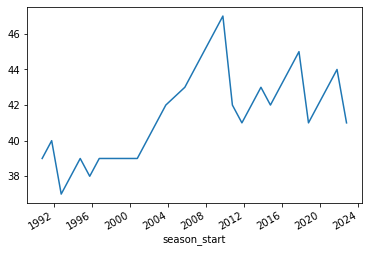

In [90]:
# avg age by season
pivot = df[year_filter].groupby("season_start")["age_season_start"].max()
pivot.plot()

## Visualise

Stripes plot for top 15 players with 

- Guide on [how to recreate Warming Stripes in Matplotlib](https://matplotlib.org/matplotblog/posts/warming-stripes/)

### Prepare data

In [227]:
# drop duplicate entries per player per season (ie. if they switched team at some point)
df_filtered = df.drop_duplicates(subset=["player_id", "season"], keep="first").reset_index(drop=True)

df_filtered = df_filtered.groupby(["player_id", "first_name", "last_name", "birth_country", "birth_date"]).agg(
    {"age_season_start": ["min", "max", lambda x: ','.join(map(str, x))],
     "season": ["min", "max","count"],
     })

# merge columns and rename
df_filtered.columns = ['_'.join(col) for col in df_filtered.columns]
df_filtered = df_filtered.rename(columns=lambda x: x.replace('_<lambda_0>', ''))

df_filtered["age_season_start"] = df_filtered["age_season_start"].str.split(",")
df_filtered["team_code"] = df_filtered["team_code"].str.split(",")

df_filtered  = df_filtered.reset_index().set_index("player_id")
age_dummies = pd.get_dummies(df_filtered['age_season_start'].apply(pd.Series).stack()).sum(level=0)
df_filtered = pd.concat([df_filtered, age_dummies], axis=1)

df_filtered = df_filtered.sort_values(by="season_count", ascending=False)
df_filtered

C:\Users\LISA~1.HOR\AppData\Local\Temp/ipykernel_19208/2640655333.py:18: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  age_dummies = pd.get_dummies(df_filtered['age_season_start'].apply(pd.Series).stack()).sum(level=0)


,first_name,last_name,birth_country,birth_date,age_season_start_min,age_season_start_max,age_season_start,team_code,season_min,season_max,...,39,40,41,42,43,44,45,46,47,51
player_id,,,,,,,,,,,,,,,,,,,,,
8446053,Chris,Chelios,USA,1962-01-25,21,47,"[47, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 2...","[ATL, DET, DET, DET, DET, DET, DET, DET, DET, ...",19831984,20092010,...,1,1,1,0,1,1,1,1,1,0
8448000,Gordie,Howe,CAN,1928-03-31,18,51,"[51, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...","[HFD, DET, DET, DET, DET, DET, DET, DET, DET, ...",19461947,19791980,...,1,1,1,1,0,0,0,0,0,1
8449573,Mark,Messier,CAN,1961-01-18,18,42,"[36, 37, 38, 30, 31, 32, 33, 34, 35, 39, 40, 4...","[VAN, VAN, VAN, NYR, NYR, NYR, NYR, NYR, NYR, ...",19791980,20032004,...,1,1,1,1,0,0,0,0,0,0
8465009,Zdeno,Chara,SVK,1977-03-18,20,44,"[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4...","[BOS, BOS, BOS, BOS, BOS, BOS, BOS, BOS, BOS, ...",19971998,20212022,...,1,1,1,1,1,1,0,0,0,0
8466138,Joe,Thornton,CAN,1979-07-02,18,42,"[18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 3...","[BOS, BOS, BOS, BOS, BOS, BOS, BOS, BOS, SJS, ...",19971998,20212022,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8457761,Dan,Ratushny,CAN,1970-10-29,21,21,[21],[VAN],19921993,19921993,...,0,0,0,0,0,0,0,0,0,0
8457824,Robert,Robinson,CAN,1967-04-19,24,24,[24],[STL],19911992,19911992,...,0,0,0,0,0,0,0,0,0,0
8457901,Andrew,Rymsha,CAN,1968-12-10,22,22,[22],[QUE],19911992,19911992,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:ylabel='player_id'>

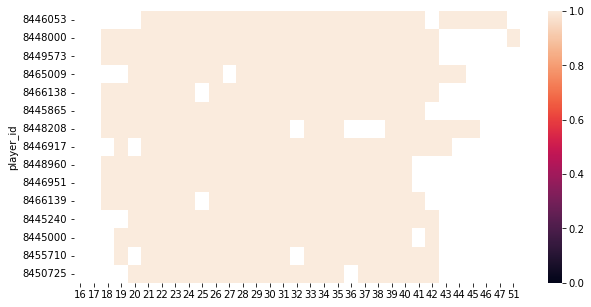

In [231]:
fig, ax = plt.subplots(figsize=(10,5))

data_for_plot = df_filtered[df_filtered.columns[11:].tolist()].replace(0, np.nan)
sns.heatmap(data_for_plot[:15], vmin=0, vmax=1, ax=ax)